<a href="https://colab.research.google.com/github/bitsym/InformerforCurve/blob/main/CurvesOT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, MultiHeadAttention, Input
from tensorflow.keras.models import Model
import numpy as np

class PositionalEncoding(Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)[tf.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
class TransformerEncoder(Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
def build_transformer(num_features, sequence_length, d_model, num_heads, ff_dim, num_layers, rate=0.1):
    inputs = Input(shape=(sequence_length, num_features))
    # Map the input features to the model dimension
    x = Dense(d_model, activation='relu')(inputs)
    # Add positional encodings
    x = PositionalEncoding(sequence_length, d_model)(x)
    for _ in range(num_layers):
        x = TransformerEncoder(d_model, num_heads, ff_dim, rate)(x)
    outputs = Dense(1, activation='linear')(x)  # Predicting 'OT1'
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the CSV file
data = pd.read_csv('CurvesT2.csv')

# Select features and target
features = data[['LOCATION', 'X SERIAL', 'Y SERIAL', 'Z SERIAL']]
target = data['OT2']

# Normalize the feature data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Check the sequence creation logic
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(0, len(features) - sequence_length + 1, sequence_length):  # Ensure no overlap if not desired
        X.append(features[i:(i + sequence_length)])
        y.append(target[i + sequence_length - 1])  # Adjust based on how you want to predict
    return np.array(X), np.array(y)

# Assuming sequence_length is correctly set and there's enough data
features_seq, target_seq = create_sequences(features_scaled, target, sequence_length=21)
print("Generated Features Shape:", features_seq.shape)
print("Generated Target Shape:", target_seq.shape)

# Generate sequences
sequence_length = 21
features_seq, target_seq = create_sequences(features_scaled, target, sequence_length)

# Split the data into training, validation, and testing sets
# Note: Adjust indices based on how you define training, validation, and testing
index_train = len(features_seq) - 2 * sequence_length  # Reserve the last 42 sequences
index_val = len(features_seq) - sequence_length  # Reserve the last 21 sequences

train_features = features_seq[:index_train]
train_target = target_seq[:index_train]

val_features = features_seq[index_train:index_val]
val_target = target_seq[index_train:index_val]

test_features = features_seq[index_val:]
test_target = target_seq[index_val:]

# Now you can proceed to define and train your model with train_features, val_features, and test_features
# Assuming the total number of sequences and the sequence length
total_sequences = features_seq.shape[0]
train_features = features_seq[:int(total_sequences * 0.8)]
train_target = target_seq[:int(total_sequences * 0.8)]
val_features = features_seq[int(total_sequences * 0.8):int(total_sequences * 0.9)]
val_target = target_seq[int(total_sequences * 0.8):int(total_sequences * 0.9)]


Generated Features Shape: (16, 21, 4)
Generated Target Shape: (16,)


In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Adjust model dimensions and architecture
d_model = 1024  # increased from 512
ff_dim = 4096   # increased from 2048
num_layers = 4  # increased from 2

model = build_transformer(num_features=4, sequence_length=21, d_model=d_model, num_heads=8, ff_dim=ff_dim, num_layers=num_layers)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Add learning rate scheduler and early stopping
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_features, train_target,
    validation_data=(val_features, val_target),
    epochs=100,
    batch_size=32,
    callbacks=[lr_scheduler, early_stopping]
)



Epoch 1/100
1/1 [==============================] - 25s 25s/step - loss: 0.7755 - val_loss: 0.6541 - lr: 1.0000e-08
Epoch 2/100
1/1 [==============================] - 13s 13s/step - loss: 0.7892 - val_loss: 0.6482 - lr: 1.1220e-08
Epoch 3/100
1/1 [==============================] - 12s 12s/step - loss: 0.8151 - val_loss: 0.6415 - lr: 1.2589e-08
Epoch 4/100
1/1 [==============================] - 12s 12s/step - loss: 0.8211 - val_loss: 0.6341 - lr: 1.4125e-08
Epoch 5/100
1/1 [==============================] - 12s 12s/step - loss: 0.7352 - val_loss: 0.6261 - lr: 1.5849e-08
Epoch 6/100
1/1 [==============================] - 12s 12s/step - loss: 0.7923 - val_loss: 0.6173 - lr: 1.7783e-08
Epoch 7/100
1/1 [==============================] - 13s 13s/step - loss: 0.7037 - val_loss: 0.6076 - lr: 1.9953e-08
Epoch 8/100
1/1 [==============================] - 12s 12s/step - loss: 0.7846 - val_loss: 0.5970 - lr: 2.2387e-08
Epoch 9/100
1/1 [==============================] - 12s 12s/step - loss: 0.8755 -

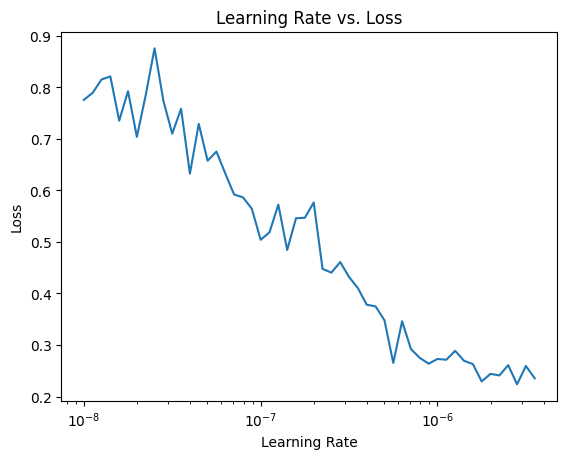

In [5]:
import matplotlib.pyplot as plt

# Plot learning rate vs loss
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs. Loss")
plt.show()


In [6]:
total_sequences = len(features_seq)
print("Total sequences available:", total_sequences)
# Make predictions on the test dataset
test_predictions = model.predict(test_features)
test_pre = test_predictions[0,:]
print(test_pre)
testPre = test_pre[:,0]
print(testPre)

Total sequences available: 16
1/1 [==============================] - 4s 4s/step
[[-0.61973155]
 [-0.96153575]
 [-1.1243702 ]
 [-1.2333906 ]
 [-1.2876408 ]
 [-1.1972754 ]
 [-0.91805667]
 [-0.7690976 ]
 [-0.9511197 ]
 [-0.9929203 ]
 [-0.954591  ]
 [-0.878691  ]
 [-0.81715196]
 [-0.7457878 ]
 [-0.48122022]
 [-0.505269  ]
 [-0.5954457 ]
 [-0.6728104 ]
 [-0.8003526 ]
 [-0.6875533 ]
 [-0.34316367]]
[-0.61973155 -0.96153575 -1.1243702  -1.2333906  -1.2876408  -1.1972754
 -0.91805667 -0.7690976  -0.9511197  -0.9929203  -0.954591   -0.878691
 -0.81715196 -0.7457878  -0.48122022 -0.505269   -0.5954457  -0.6728104
 -0.8003526  -0.6875533  -0.34316367]


In [7]:
print(test_target)
print(target)
testY = target[-21:]
print(testY)
print(testY)
print(len(testY))
testY = testY.to_numpy()


[-0.81602  -0.835173 -0.835163 -0.835151 -0.835161]
0     -0.420174
1     -0.567696
2     -0.744875
3     -0.832411
4     -0.850371
         ...   
331   -0.787665
332   -0.757685
333   -0.763290
334   -0.804168
335   -0.835161
Name: OT2, Length: 336, dtype: float64
315   -0.562738
316   -0.665410
317   -0.812475
318   -0.845901
319   -0.854875
320   -0.860082
321   -0.863092
322   -0.865011
323   -0.865004
324   -0.858831
325   -0.840053
326   -0.816774
327   -0.791881
328   -0.764618
329   -0.788960
330   -0.800580
331   -0.787665
332   -0.757685
333   -0.763290
334   -0.804168
335   -0.835161
Name: OT2, dtype: float64
315   -0.562738
316   -0.665410
317   -0.812475
318   -0.845901
319   -0.854875
320   -0.860082
321   -0.863092
322   -0.865011
323   -0.865004
324   -0.858831
325   -0.840053
326   -0.816774
327   -0.791881
328   -0.764618
329   -0.788960
330   -0.800580
331   -0.787665
332   -0.757685
333   -0.763290
334   -0.804168
335   -0.835161
Name: OT2, dtype: float64
21


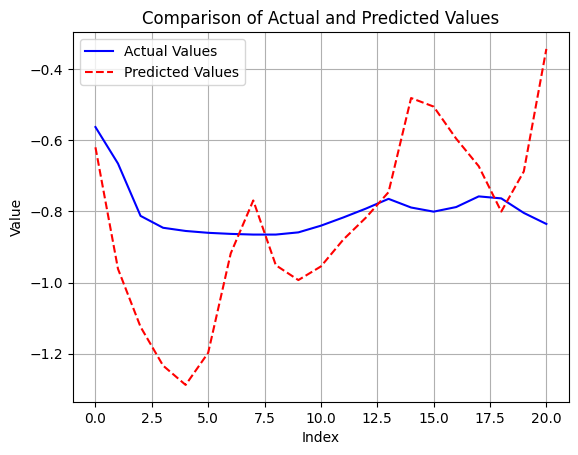

In [8]:
import matplotlib.pyplot as plt

# Assuming test_target is correctly aligned with test_predictions
# plt.figure(figsize=(12, 6))
plt.plot(testY, label='Actual Values', linestyle='-', color='blue')
plt.plot(testPre, label='Predicted Values', linestyle='--', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
import pandas as pd

# Create a DataFrame with both testY and testPre
data = {
    'Actual Values': testY,
    'Predicted Values': testPre
}
df = pd.DataFrame(data)
# Saving the DataFrame to a CSV file
df.to_csv('predictions_comparison_OT2.csv', index=False)
# Saving each vector to its own CSV file
df_actual = pd.DataFrame(testY, columns=['Actual Values'])
df_predicted = pd.DataFrame(testPre, columns=['Predicted Values'])

df_actual.to_csv('actual_valuesOT2.csv', index=False)
df_predicted.to_csv('predicted_valuesOT2.csv', index=False)
